# NEW high-energy analysis
This notebook demonstrates the main components of the high-energy analysis, which consists of several main steps in the following order:

1. Determine the correction for the z-effect by plotting energy (uncorrected) vs. Z and fitting the resulting 2D distribution in the region of interest.  The fit slope/intercept for each peak can be considered in deciding on the final correction factor $(m/b)$: $E \rightarrow E/(1 + (m/b)\Delta z)$

2. Fit the three peaks (Cs photopeak, $^{208}$Tl double-escape peak, and $^{208}$Tl photopeak) AFTER application of the z-correction to determine their means to be used in the calibration.

3. Perform the calibration.  Fit the peaks again to determine the energy resolution.

In [13]:
%matplotlib inline

import os
import textwrap
import math

import datetime as dt
import pandas as pd

import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

import numpy             as np
import tables            as tb

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.reco.tbl_functions  as tbl
import invisible_cities.sierpe.blr          as blr

from   invisible_cities.icaro. hst_functions   import display_matrix
from   invisible_cities.database               import load_db

from   matplotlib                              import gridspec
from   matplotlib.patches                      import Ellipse
from   scipy.optimize                          import curve_fit
from   scipy.interpolate                       import interp1d
from   scipy                                   import stats

from   matplotlib.colors                       import SymLogNorm

# Formatting options
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['patch.force_edgecolor'] = False
mpl.rcParams['patch.facecolor'] = 'gray'
hargs = {'histtype': 'stepfilled', 'edgecolor': 'black', 'facecolor': 'gray'}

# Options for saving plots
save_dir = "fig_highenergy"  # Directory to which figures will be stored.
save_ftype = "pdf"            # Figure extension ("pdf", "png", etc.)

if(not os.path.isdir(save_dir)):
    os.mkdir(save_dir)

-------------------------

# Section A: Load event information

In [20]:
# Get the data.
! wget https://www.dropbox.com/s/gf77oxotowxu65o/ntuple_combined_50_7430.h5
! wget https://www.dropbox.com/s/vcn3u4ggfszeprj/ntuple_combined_50_7431.h5
! wget https://www.dropbox.com/s/mbuaqo8za45nncq/ntuple_combined_50_7432.h5
! wget https://www.dropbox.com/s/nqe8rgkcdgj0bne/ntuple_combined_50_7433.h5
! wget https://www.dropbox.com/s/a6lmbb4l7p30kh4/ntuple_combined_50_7435.h5

--2019-10-10 17:50:55--  https://www.dropbox.com/s/gf77oxotowxu65o/ntuple_combined_50_7430.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.68.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.68.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/gf77oxotowxu65o/ntuple_combined_50_7430.h5 [following]
--2019-10-10 17:50:56--  https://www.dropbox.com/s/raw/gf77oxotowxu65o/ntuple_combined_50_7430.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfa18e885fe90e09c89c8b79a1e.dl.dropboxusercontent.com/cd/0/inline/AqJI69-CuPyGkZCbqY7cZdEWZeaJXVycmpwoiF_RhjSEU57heflo07nlf-X5-qM8BAgt8n7r8YzpRcyCV_-1Pzu6IRehvXoodVDPSfg1yty-NuOjFOu-9RuqG6sLVJfuAmE/file# [following]
--2019-10-10 17:50:56--  https://ucfa18e885fe90e09c89c8b79a1e.dl.dropboxusercontent.com/cd/0/inline/AqJI69-CuPyGkZCbqY7cZdEWZeaJXVycmpwoiF_RhjSEU57heflo07nlf-X5-qM8BAgt8n7r8YzpRcyCV_-1Pzu6IRehvXood

HTTP request sent, awaiting response... 200 OK
Length: 67013853 (64M) [application/octet-stream]
Saving to: ‘ntuple_combined_50_7432.h5’

ntuple_combined_50_ 100%[===================>]  63.91M  34.8MB/s    in 1.8s    

2019-10-10 17:51:18 (34.8 MB/s) - ‘ntuple_combined_50_7432.h5’ saved [67013853/67013853]

--2019-10-10 17:51:18--  https://www.dropbox.com/s/nqe8rgkcdgj0bne/ntuple_combined_50_7433.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.68.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.68.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/nqe8rgkcdgj0bne/ntuple_combined_50_7433.h5 [following]
--2019-10-10 17:51:18--  https://www.dropbox.com/s/raw/nqe8rgkcdgj0bne/ntuple_combined_50_7433.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1cc2383725cb7d6243b2b7bec5.dl.dropboxusercontent.com/cd/0/inline/AqInA4njogjgdQFqjKk7hWMaaTh8-iPJe3acIM

## A.1: Combine information from various Esmeralda files into a single file
Note that this only needs to be run once for a single run.

In [ ]:
def combine_esmeralda_files(esmeralda_dir,combined_file):
    
    # Obtain a sorted list of the files to combine.
    files = glob(esmeralda_dir + '/ntuple_*.h5')
    files = sorted(files, key=lambda s: int(s.split('.')[-2].split('_')[-1]))

    # Open the final tables file.
    fcombined = tables.open_file(out_file, "w", filters=tables.Filters(complib="blosc", complevel=9))
    group_PAOLINA = fcombined.create_group(fcombined.root, "PAOLINA")
    
    # Process the first file.
    f1 = tables.open_file(files[0], 'r')
    print("-- Adding file {0}".format(files[0]));
    paolina_combined = f1.copy_node('/PAOLINA', name='Summary', newparent=group_PAOLINA)
    f1.close()

    # Process the remaining files.
    for fn in files[1:]:

        # Open the next file and extract the elements.
        fn = tables.open_file(fn, 'r')
        print("-- Adding file {0}".format(fn));
        if("/PAOLINA/Summary" in fn):
            paolina_n = fn.root.PAOLINA.Summary
            paolina_combined.append(paolina_n.read())
        else:
            print(" --> Skipping file due to no table found")
        fn.close()
        fcombined.flush()

    # Close the combined file.
    print("Saving combined file {0}".format(combined_file))
    fcombined.close()

In [ ]:
combine_esmeralda_files(esmeralda_dir = "/analysis/{}/hdf5/ntuple/trigger{}".format(run,trigger_num),
                        out_file = "ntuple_combined_{}.h5".format(out_dir,run))

## A.2: Load the information from combined files

The information from the Esmeralda step from each of the combined files is loaded into numpy arrays.  The names of the files to be combined are specified below.

The file information will be loaded into numpy arrays as follows:

`A_evtnum`      -- event number<br>
`A_time`        -- timestamp<br>
`A_eblob1`      -- energy of blob1 (most energetic) as obtained from Paolina analysis<br>
`A_eblob2`      -- energy of blob2 (least energetic) as obtained from Paolina analysis<br>
`A_emtrk`       -- energy of 10 most energetic Paolina tracks in the event<br>
`A_xmtrk`       -- average reconstructed $x$-coordinate of 10 most energetic Paolina tracks in the event<br>
`A_ymtrk`       -- average reconstructed $y$-coordinate of 10 most energetic Paolina tracks in the event<br>
`A_zmtrk`       -- average reconstructed $z$-coordinate of 10 most energetic Paolina tracks in the event<br>
`A_ntrks`       -- number of tracks in the event<br>
`A_lmtrk`       -- length of most energetic Paolina track in event<br>
`A_nvox`        -- number of voxels in the event<br>
`A_nhits`       -- number of hits in the event<br>
`A_Ec`          -- fully corrected energy (lifetime by hit + $(x,y)$ by hit)<br>
`A_Eczlen`      -- fully corrected energy + z-length correction<br>
`A_E0`          -- uncorrected energy<br>
`A_xavg`        -- average reconstructed $x$-coordinate of event<br>
`A_yavg`        -- average reconstructed $y$-coordinate of event<br>
`A_zavg`        -- average reconstructed $z$-coordinate of event<br>
`A_ravg`        -- average $r = \sqrt{x^2 + y^2}$ of event<br>
`A_xmin`        -- minimum reconstructed $x$-coordinate of event<br>
`A_ymin`        -- minimum reconstructed $y$-coordinate of event<br>
`A_zmin`        -- minimum reconstructed $z$-coordinate of event<br>
`A_xmax`        -- maximum reconstructed $x$-coordinate of event<br>
`A_ymax`        -- maximum reconstructed $y$-coordinate of event<br>
`A_zmax`        -- maximum reconstructed $z$-coordinate of event<br>
`A_rmin`        -- minimum value of $r = \sqrt{x^2 + y^2}$ over all hits in event<br>
`A_rmax`        -- maximum value of $r = \sqrt{x^2 + y^2}$ over all hits in event<br>

In [7]:
# Calibration information: set to a = 0, b = 1, c = 0 for default calibration.
CAL_a = -0.006680368665624783
CAL_b = 0.9571139335090242
CAL_c = 0.010639589186562352

z_corrected = True

# Define a calibration function for use later.
def StoE(spes):
    return CAL_a*spes**2 + CAL_b*spes + CAL_c

In [21]:
# Names of the combined files, each containing the information from the Esmeralda step for all events in a single run.
evtfnames   = ["ntuple_combined_50_7430.h5",
                "ntuple_combined_50_7431.h5",
                "ntuple_combined_50_7432.h5",
                "ntuple_combined_50_7433.h5",
                "ntuple_combined_50_7435.h5"]

In [22]:
A_evtnum = []; A_time = []; A_ES1 = []
A_eblob1 = []; A_eblob2 = []; A_emtrk = []; A_etrks = []; A_xtrks = []; A_ytrks = []; A_ztrks = []
A_ntrks = []; A_lmtrk = []; A_nvox = []; A_nhits = []
A_Ec = []; A_Eczlen = []; A_E0 = []; A_Echead = []; A_Ectail = []
A_xavg = []; A_yavg = []; A_zavg = []; A_ravg = []
A_xmin = []; A_ymin = []; A_zmin = []
A_xmax = []; A_ymax = []; A_zmax = []
A_rmin = []; A_rmax = []
for ii,fname in enumerate(evtfnames):
 
    print("Adding file {} ...".format(fname))
    ftbl = tb.open_file(fname, 'r')
    fn = ftbl.root.PAOLINA.Summary[:]
    
    A_evtnum = np.concatenate((A_evtnum,fn['event']))
    A_time   = np.concatenate((A_time,fn['time']))
    A_ES1    = np.concatenate((A_ES1,fn['S1e']))
    A_ntrks  = np.concatenate((A_ntrks,fn['ntrks']))
    A_nhits  = np.concatenate((A_nhits,fn['nhits']))
    A_Ec     = np.concatenate((A_Ec,fn['S2ec']))
    A_E0     = np.concatenate((A_E0,fn['S2e0']))
    A_xavg   = np.concatenate((A_xavg,fn['x_avg']))
    A_yavg   = np.concatenate((A_yavg,fn['y_avg']))
    A_zavg   = np.concatenate((A_zavg,fn['z_avg']))
    A_ravg   = np.concatenate((A_ravg,fn['r_avg']))
    A_xmin   = np.concatenate((A_xmin,fn['x_min']))
    A_ymin   = np.concatenate((A_ymin,fn['y_min']))
    A_zmin   = np.concatenate((A_zmin,fn['z_min']))
    A_xmax   = np.concatenate((A_xmax,fn['x_max']))
    A_ymax   = np.concatenate((A_ymax,fn['y_max']))
    A_zmax   = np.concatenate((A_zmax,fn['z_max']))
    A_rmin   = np.concatenate((A_rmin,fn['r_min']))
    A_rmax   = np.concatenate((A_rmax,fn['r_max']))

# Calibrate the energy.
A_Ecal = CAL_a*A_Ec**2 + CAL_b*A_Ec + CAL_c

# Correct for z-length effect.
A_zlen = A_zmax - A_zmin
A_Eczlcorr = A_Ecal/(1 - 2.76e-4*A_zlen)

if(z_corrected):
    A_Ecplot = A_Eczlcorr
else:
    A_Ecplot = A_Ecal

print("{} total events".format(len(A_evtnum)))

Adding file ntuple_combined_50_7430.h5 ...
Adding file ntuple_combined_50_7431.h5 ...
Adding file ntuple_combined_50_7432.h5 ...
Adding file ntuple_combined_50_7433.h5 ...
Adding file ntuple_combined_50_7435.h5 ...
3452757 total events


## A.3: Definition of cuts and key quantities

In [23]:
# Key variables in constructing cuts.
Emin = StoE(0); Emax = StoE(800000)                  # basic cut energy range
cwide_zmin = 50; cwide_zmax = 500
cwide_rmax = 180
ctight_zmin = 150; ctight_zmax = 300
ctight_rmax = 150

# ------------------------------------------------------------------------------------------
# Pre-defined cuts
C_basic       = (A_E0 > 0) & (A_Ecplot > 0) & (A_zavg < 580)
C_wide        = C_basic & (A_zmin > cwide_zmin) & (A_zmax < cwide_zmax) & (A_rmax < cwide_rmax)
C_tight       = C_basic & (A_zmin > ctight_zmin) & (A_zmax < ctight_zmax) & (A_rmax < ctight_rmax)
C_tfiducial   = (abs(A_xmax) < 100) & (abs(A_ymax) < 100) & (abs(A_xmin) < 100) & (abs(A_ymin) < 100) & (A_zavg > 50) & (A_zavg < 150)

# Tabulated peak energies (in keV)
E_xKalpha = (29.112*0.00261 + 29.461*25.6 + 29.782*47.4)/(0.00261 + 25.6 + 47.4)
E_xKbeta  = (33.562*4.35 + 33.624*8.40 + 33.881*0.085 + 34.419*2.54 + 34.496*0.492)/(4.35 + 8.40 + 0.085 + 2.54 + 0.492)
E_Kr      = 41.543
E_238     = 238.632
E_511     = 511
E_583     = 583.191
E_Cs      = 661.657
E_descape = 1592.535
E_Tl      = 2614.533
E_0vbb    = 2458 
print("""
E_xKalpha = {}
E_xKbeta = {}
E_Kr = {}
E_238 = {}
E_511 = {}
E_583 = {}
E_Cs = {}
E_descape = {}
E_Tl = {}
""".format(E_xKalpha,E_xKbeta,E_Kr,E_238,E_511,E_583,E_Cs,E_descape,E_Tl))

# Tabulated peak uncertainties.
err_E_Cs = 0.07
err_E_descape = 0.12
err_E_Tl = 0.3


E_xKalpha = 29.669410207662434
E_xKbeta = 33.76268210751875
E_Kr = 41.543
E_238 = 238.632
E_511 = 511
E_583 = 583.191
E_Cs = 661.657
E_descape = 1592.535
E_Tl = 2614.533



--------------------------

# Section B: The z-effect

## B.1: Function definitions

In [11]:
# A linear function mx + b
def flinear(x, m, b):
    return m*x + b

# Plot the energy vs. z-length.
def plot_E_vs_zlength(L_zlen, L_Ecplot, cuts_base, plt_rng_zlow, plt_rng_zhigh, plt_rng_Elow, plt_rng_Ehigh, nbins_E, nbins_z, mbound, b0, b1, plt_corrected = False):
    
    # Construct the cuts including the range in (z,E) space to be examined.
    cuts_bounds = (L_Ecplot > L_zlen*mbound + b0) & (L_Ecplot < L_zlen*mbound + b1)
    cuts_range = cuts_base & (L_zlen > plt_rng_zlow) & (L_zlen < plt_rng_zhigh) & (L_Ecplot > plt_rng_Elow) & (L_Ecplot < plt_rng_Ehigh)
    cuts_all = cuts_range & cuts_bounds
    
    # Assume an approximate 1% FWHM sigma on the energy measurements.
    esigma = 1.0*np.mean(L_Ecplot[cuts_all])/235
    
    # Perform the linear fit and extract the parameters.
    p_fit, V_fit = curve_fit(flinear, L_zlen[cuts_all], L_Ecplot[cuts_all], sigma=np.ones(len(L_zlen[cuts_all]))*esigma)
    m = p_fit[0]
    b = p_fit[1]
    var_m = V_fit[0][0]
    var_b = V_fit[1][1]
    var_mb = V_fit[0][1]
    xfit = np.arange(plt_rng_zlow, plt_rng_zhigh, (plt_rng_zhigh-plt_rng_zlow)/100)
    polyfit = np.poly1d([m, b])
    mb_err = (var_m/b**2 + m**2*var_b/b**4 - m*var_mb/b**3)**0.5
    print("Slope for correction {} +/- {}; intercept: {} +/- {}".format(m, var_m**0.5, b, var_b**0.5))
    print("Uncertainty in m/b = {}".format(mb_err))
    
    # Construct the boundary polynomials.
    polyfit_b0 = np.poly1d([mbound, b0])
    polyfit_b1 = np.poly1d([mbound, b1])
    
    # Create the plot.
    fig = plt.figure()
    fig.set_figheight(6.0)
    fig.set_figwidth(16.0)
    
    ax1 = fig.add_subplot(121)
    h, x, y = np.histogram2d(-L_Ecplot[cuts_range], L_zlen[cuts_range], bins=[nbins_E, nbins_z], range=[[-plt_rng_Ehigh,-plt_rng_Elow],[plt_rng_zlow,plt_rng_zhigh]])
    plt.imshow(h, extent=[plt_rng_zlow,plt_rng_zhigh,plt_rng_Elow,plt_rng_Ehigh], interpolation = "none", cmap='jet', aspect=(plt_rng_zhigh-plt_rng_zlow)/(plt_rng_Ehigh-plt_rng_Elow))
    plt.plot(xfit, polyfit_b0(xfit), '--', color='red')
    plt.plot(xfit, polyfit_b1(xfit), '--', color='red')
    plt.plot(xfit, polyfit(xfit), '-', color='red', linewidth=3, label="m/b = {:.2f} $\\times 10^{{-4}} \pm$ {:.2f} mm$^{{-1}}$".format(m/b*1e4,mb_err*1e4))
    plt.locator_params(axis='y', nbins=7)
    plt.legend(loc=1, fontsize=14)
    plt.colorbar()
    plt.ylim([plt_rng_Elow,plt_rng_Ehigh])
    plt.xlim([plt_rng_zlow,plt_rng_zhigh])
    plt.xlabel('z-length (mm)')
    plt.ylabel('E (SPEs)')
    
    # Plot the corrected energy vs. z-length alongside the uncorrected plot.
    #  Note: this should only be enabled if the energies in L_Ecplot are uncorrected.
    if(plt_corrected):
        E_rng = plt_rng_Ehigh - plt_rng_Elow
        ax2 = fig.add_subplot(122)
        h, x, y = np.histogram2d(-L_Ecplot[cuts_range]/(1+(m/b)*L_zlen[cuts_range]), L_zlen[cuts_range], bins=[nbins_E, nbins_z], range=[[-(b+E_rng/2),-(b-E_rng/2)],[plt_rng_zlow,plt_rng_zhigh]])
        plt.imshow(h, extent=[plt_rng_zlow,plt_rng_zhigh,b-E_rng/2,b+E_rng/2], interpolation = "none", cmap='jet', aspect=(plt_rng_zhigh-plt_rng_zlow)/E_rng)
        plt.plot(xfit, polyfit_b0(xfit), '--', color='red')
        plt.plot(xfit, polyfit_b1(xfit), '--', color='red')
        plt.plot(xfit, polyfit(xfit), '-', color='red', linewidth=3, label="m/b = {:.2f} $\\times 10^{{-4}}$ mm$^{{-1}}$".format(m/b*1e4))
        plt.legend(loc=1, fontsize=14)
        plt.colorbar()
        plt.title("Energy vs. z-length, CORRECTED")
        plt.ylim([b-E_rng/2,b+E_rng/2])
        plt.xlim([plt_rng_zlow,plt_rng_zhigh])
        plt.xlabel('z-length (mm)')
        plt.ylabel('E (SPEs)')

## B.2: Z-effect for each peak

Slope for correction -0.00027710513777494557 +/- 2.2518191952663972e-05; intercept: 0.6780676745446661 +/- 0.0005150323858486882
Uncertainty in m/b = 3.3060630632462495e-05


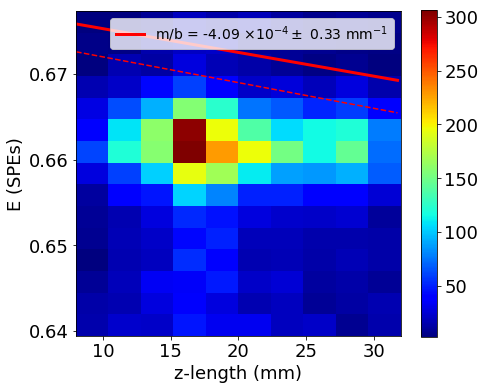

In [14]:
# Cs peak
mbound = -0.0003
b0 = 0.675
b1 = 0.697
plt_rng_zlow = 8
plt_rng_zhigh = 32
plt_rng_Elow = StoE(0.660)
plt_rng_Ehigh = StoE(0.700)

cuts_base = C_wide & (A_ntrks == 1)
plot_E_vs_zlength(A_zlen, A_Ecplot, cuts_base, plt_rng_zlow, plt_rng_zhigh, plt_rng_Elow, plt_rng_Ehigh, 15, 10, mbound, b0, b1)
plt.savefig("{}/CSTH_zwidth_fit_Cs.{}".format(save_dir,'png'), bbox_inches='tight')

In [ ]:
# 208Tl double-escape peak
mbound = -0.0008
b0 = 1.67
b1 = 1.705
plt_rng_zlow = 15
plt_rng_zhigh = 80
plt_rng_Elow = StoE(1.62)
plt_rng_Ehigh = StoE(1.70)

cuts_base = C_wide & (A_ntrks == 1)
plot_E_vs_zlength(A_zlen, A_Ecplot, cuts_base, plt_rng_zlow, plt_rng_zhigh, plt_rng_Elow, plt_rng_Ehigh, 15, 15, mbound, b0, b1)
plt.savefig("{}/CSTH_zwidth_fit_DE.{}".format(save_dir,'png'), bbox_inches='tight')

In [ ]:
# Tl photopeak
mbound = -0.0008
b0 = 2.73
b1 = 2.83
plt_rng_zlow = 30
plt_rng_zhigh = 180
plt_rng_Elow = StoE(2.65)
plt_rng_Ehigh = StoE(2.78)

cuts_base = C_wide & (A_ntrks == 1)
plot_E_vs_zlength(A_zlen, A_Ecplot, cuts_base, plt_rng_zlow, plt_rng_zhigh, plt_rng_Elow, plt_rng_Ehigh, 15, 15, mbound, b0, b1)
plt.savefig("{}/CSTH_zwidth_fit_Tl.{}".format(save_dir,'png'), bbox_inches='tight')

# Section C: Energy peaks

## C.1: Function definitions

In [15]:
# Return errors on resolution extrapolated to Qbb
def reso_errors(values,errors,epeak):
    _, mu, sigma = values
    _, err_mu, err_sigma = errors
    r = 235. * sigma/mu
    err_r = r*np.sqrt((err_sigma/sigma)**2 + (err_mu/mu)**2)
    return r, err_r, r * (epeak/2458)**0.5, err_r * (epeak/2458)**0.5

# Returns text output for Gaussian fit function
def gausstext_err(values,errors,chisq,epeak):
    r,err_r,rbb,err_rbb = reso_errors(values,errors,epeak)
    return textwrap.dedent("""
        $\mu$ = {:.5f} $\pm$ {:.5f}
        $\sigma$ = {:.5f} $\pm$ {:.5f}
        R (%) = {:.2f} $\pm$ {:.2f}
        $\chi^2$/N$_\mathrm{{dof}}$ = {:.2f}""".format(values[1],errors[1],values[2],errors[2],r,err_r,chisq))

def plt_spectrum(energies, ecuts, plt_rng_low, plt_rng_high, fit_rng_low, fit_rng_high, 
                  fit_gauss_A, fit_gauss_mu, fit_gauss_sigma, text_x, nbins, outfile_name):
    
    fig = plt.figure(1)
    fig.patch.set_alpha(0.0)
    fig.set_figheight(4.8)
    fig.set_figwidth(6.0)

    # Make the histogram.
    y0, x0, _ = plt.hist(energies[ecuts], nbins, range=[plt_rng_low, plt_rng_high], **hargs)

    # Gaussian fit
    x    = x0[:-1] + np.diff(x0) * 0.5
    sel  = coref.in_range(x, fit_rng_low, fit_rng_high)
    x, y, sig = x[sel], y0[sel], np.sqrt(y0[sel])
    f    = fitf.fit(lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.polynom(x, *args[3:]), x, y, (fit_gauss_A, fit_gauss_mu, fit_gauss_sigma, 1, -1/fit_gauss_mu, -1/fit_gauss_mu**2), sigma=sig)
    plt.plot(x, f.fn(x), "r")
    plt.text(text_x, 4.2*max(y)/6, gausstext_err(f.values[0:3],f.errors[0:3],f.chi2,E_238),fontsize=14)
    plt.xlabel('E (keV)')
    plt.ylabel('Counts/bin')
    print("Fit parameters are (amp, mu, sigma, A, mean, x0)")
    print(f.values)
    print("Fit errors are (amp, mu, sigma)")
    print(f.errors)
    print("Fit p-value assuming obtained chi2 and 1 d.o.f. is {}".format(1-stats.chi2.cdf(f.chi2, 1)))
    
    # Save the plot to file.
    plt.savefig("{}/{}.{}".format(save_dir, outfile_name, save_ftype), bbox_inches='tight')

    # Compute the statistical error.
    mu = f.values[1]
    sigma = f.values[2]
    s_mu = f.errors[1]
    s_sigma = f.errors[2]
    R = sigma/mu
    s_R = (s_sigma**2 + R**2*s_mu**2)**0.5/mu
    print("Fit range: ({},{})".format(fit_rng_low,fit_rng_high))
    print("Fit range from mu in sigma: ({},{})".format((fit_rng_low-mu)/sigma,(fit_rng_high-mu)/sigma))
    print("Resolution is {} +/- {}".format(235*R,235*s_R))
    print("Resolution at Qbb is {} +/- {}".format(235*R*(E_238/E_0vbb)**0.5,235*s_R*(E_238/E_0vbb)**0.5))
    
    # Return the fit result.
    return f
    
def plt_xyz_distributions(xavg, yavg, zavg, cuts_xyz, nxybins, nzbins, zmin, zmax, rmax, outfile_name):

    fig = plt.figure(2)
    fig.patch.set_alpha(0.0)
    fig.set_figheight(4.0)
    fig.set_figwidth(12.0)

    # x-y distribution
    ax1 = fig.add_subplot(121)
    h, x, y = np.histogram2d(-yavg[cuts_xyz], xavg[cuts_xyz], bins=[nxybins, nxybins], range=[[-215, 215], [-215, 215]])
    plt.imshow(h, extent=[x[0],x[-1],y[0],y[-1]], interpolation = "gaussian", cmap='jet')
    plt.colorbar()
    plt.xlabel("average x (mm)")
    plt.ylabel("average y (mm)")
    ctight_circle = plt.Circle((0, 0), rmax, color='gray', alpha=0.15)
    ctight_lcircle = plt.Circle((0, 0), rmax, facecolor='none', linestyle='solid', edgecolor='red',linewidth=2)
    plt.gca().add_artist(ctight_lcircle)

    # z distribution
    ax2 = fig.add_subplot(122)
    hz = plt.hist(zavg[cuts_xyz], bins=nzbins, range=[0,580], **hargs)
    plt.xlabel("average z (mm)")
    plt.axvline(zmin,linestyle='solid',color='red',linewidth=1.2)
    plt.axvline(zmax,linestyle='solid',color='red',linewidth=1.2)
    plt.axvspan(zmin,zmax,linestyle='solid',facecolor='gray',edgecolor='red',linewidth=1.2,alpha=0.05)

    plt.savefig("{}/{}.{}".format(save_dir, outfile_name, save_ftype), bbox_inches='tight')

## C.2: Full energy spectrum

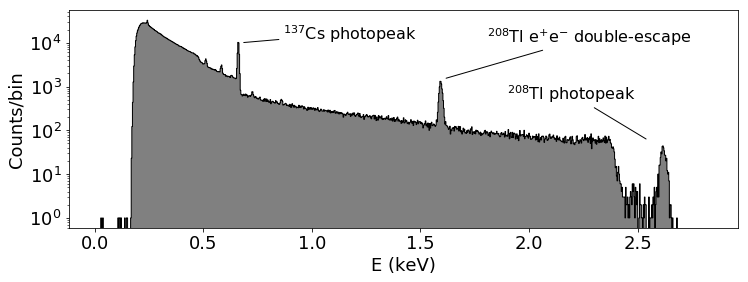

In [24]:
cuts_fullspectrum = C_wide & (A_ntrks == 1)

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

y, x, _ = plt.hist(A_Ecplot[cuts_fullspectrum], 1000, range=[StoE(0.01),StoE(3.0)], **hargs)
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')
plt.yscale('log')
plt.annotate('$^{137}$Cs photopeak', xy=(StoE(0.70), 10000),  xycoords='data',
                 xytext=(StoE(0.90), 12000), textcoords='data', fontsize=16,
                 arrowprops=dict(arrowstyle="-"))
plt.annotate('$^{208}$Tl e$^{+}$e$^{-}$ double-escape', xy=(StoE(1.69), 1500),  xycoords='data',
                 xytext=(StoE(1.9), 10000), textcoords='data', fontsize=16,
                 arrowprops=dict(arrowstyle="-"))
plt.annotate('$^{208}$Tl photopeak', xy=(StoE(2.7), 60),  xycoords='data',
                xytext=(StoE(2.0), 500), textcoords='data', fontsize=16,
                arrowprops=dict(arrowstyle="-"))

plt.savefig("{}/CSTH_espectrum_full.{}".format(save_dir,save_ftype), bbox_inches='tight')


## C.3: Fit individual peaks

### Cs peak: 662 keV

Fit parameters are (amp, mu, sigma, A, mean, x0)
[ 1.87025462e+01  6.61733299e-01  3.33594735e-03  5.80782861e+04
 -1.67600886e+05  1.21144515e+05]
Fit errors are (amp, mu, sigma)
[2.20238639e-01 2.53005578e-05 3.13364853e-05 2.60886302e+04
 7.88990185e+04 5.96293245e+04]
Fit p-value assuming obtained chi2 and 1 d.o.f. is 0.2587289385873801
Fit range: (0.6446402417884072,0.6782937167337316)
Fit range from mu in sigma: (-5.123898934316722,4.964232376674344)
Resolution is 1.1846881958729731 +/- 0.011128554430586008
Resolution at Qbb is 0.3691284019255037 +/- 0.0034674655550832032


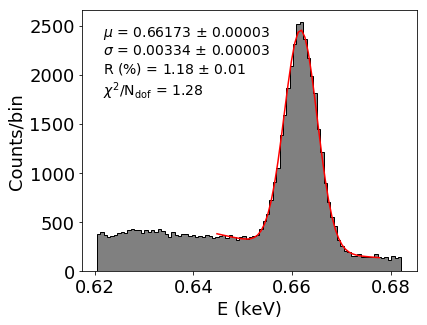

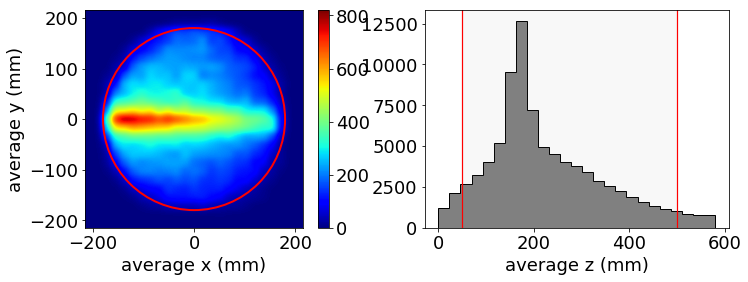

In [25]:
cuts_energy = C_basic & (A_rmax < cwide_rmax) & (A_zmin > cwide_zmin) & (A_zmax < cwide_zmax) & \
              (A_zlen > 8) & (A_zlen < 32) & (A_ntrks == 1)

if(z_corrected):
    
    fit_rng_low = StoE(0.6655)
    fit_rng_high = StoE(0.701)
    
    f = plt_spectrum(A_Ecplot, cuts_energy, 
                  plt_rng_low = StoE(0.640),
                  plt_rng_high = StoE(0.705),
                  fit_rng_low = fit_rng_low,
                  fit_rng_high = fit_rng_high,
                  fit_gauss_A = 3500,
                  fit_gauss_mu = StoE(0.682),
                  fit_gauss_sigma = StoE(0.005),
                  text_x = 1.002*StoE(0.640),
                  nbins = 90,
                  outfile_name = "CSTH_espectrum_Cs_fit_zcorrected")
    
    cuts_xyz = C_basic & (A_Ecplot > fit_rng_low) & (A_Ecplot < fit_rng_high)
    plt_xyz_distributions(A_xavg, A_yavg, A_zavg, cuts_xyz, 
                          nxybins = 25, 
                          nzbins = 25, 
                          zmin = cwide_zmin, 
                          zmax = cwide_zmax, 
                          rmax = cwide_rmax,
                          outfile_name = "CSTH_xyzdist_Cs")

    
else:

    fit_rng_low = StoE(0.661)
    fit_rng_high = StoE(0.699)
    
    f = plt_spectrum(A_Ecplot, cuts_energy, 
                  plt_rng_low = StoE(0.640),
                  plt_rng_high = StoE(0.700),
                  fit_rng_low = fit_rng_low,
                  fit_rng_high = fit_rng_high,
                  fit_gauss_A = 3500,
                  fit_gauss_mu = StoE(0.682),
                  fit_gauss_sigma = StoE(0.005),
                  text_x = 1.002*StoE(0.640),
                  nbins = 90,
                  outfile_name = "CSTH_espectrum_Cs_fit_nozcorrection")
    
    cuts_xyz = C_basic & (A_Ecplot > fit_rng_low) & (A_Ecplot < fit_rng_high)
    plt_xyz_distributions(A_xavg, A_yavg, A_zavg, cuts_xyz, 
                          nxybins = 25, 
                          nzbins = 25, 
                          zmin = cwide_zmin, 
                          zmax = cwide_zmax, 
                          rmax = cwide_rmax,
                          outfile_name = "CSTH_xyzdist_Cs")

# Save relevant values for later use.
mu_cs_fid, e_mu_cs_fid, sigma_cs_fid, e_sigma_cs_fid = f.values[1], f.errors[1], f.values[2], f.errors[2]

### 208Tl double-escape peak: 1592 keV

Fit parameters are (amp, mu, sigma, A, mean, x0)
[ 8.52963061e+00  1.59291278e+00  6.72065771e-03  1.08475419e+04
 -1.35607860e+04  4.25613422e+03]
Fit errors are (amp, mu, sigma)
[2.08147226e-01 1.05183659e-04 1.31162459e-04 1.74051979e+04
 2.18600878e+04 6.86188789e+03]
Fit p-value assuming obtained chi2 and 1 d.o.f. is 0.21670915632812437
Fit range: (1.5585980043952556,1.6259017886050202)
Fit range from mu in sigma: (-5.105865769242511,4.90859815221222)
Resolution is 0.991488411771898 +/- 0.019350308926752054
Resolution at Qbb is 0.3089306825542634 +/- 0.006029222402805698


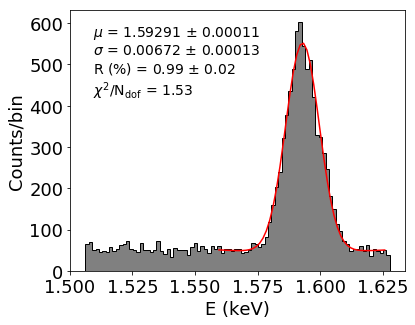

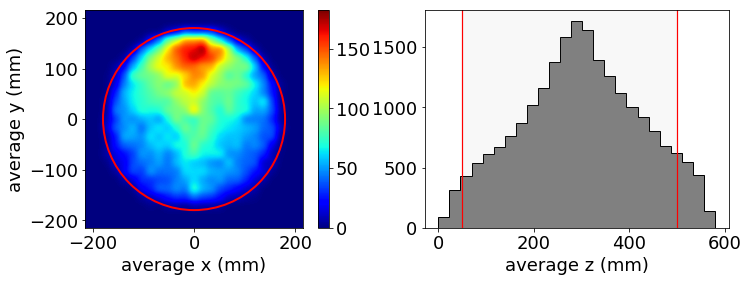

In [26]:
cuts_energy = C_basic & (A_rmax < cwide_rmax) & (A_zmin > cwide_zmin) & (A_zmax < cwide_zmax) & \
              (A_zlen > 24) & (A_zlen < 72) & (A_ntrks == 1)

if(z_corrected):
    
    fit_rng_low = StoE(1.636)
    fit_rng_high = StoE(1.708)
    
    f = plt_spectrum(A_Ecplot, cuts_energy, 
                  plt_rng_low = StoE(1.58),
                  plt_rng_high = StoE(1.71),
                  fit_rng_low = fit_rng_low,
                  fit_rng_high = fit_rng_high,
                  fit_gauss_A = 100,
                  fit_gauss_mu = StoE(1.67),
                  fit_gauss_sigma = StoE(0.1),
                  text_x = 1.002*StoE(1.58),
                  nbins = 90,
                  outfile_name = "CSTH_espectrum_DE_fit")
    
    cuts_xyz = C_basic & (A_Ecplot > fit_rng_low) & (A_Ecplot < fit_rng_high)
    plt_xyz_distributions(A_xavg, A_yavg, A_zavg, cuts_xyz, 
                          nxybins = 25, 
                          nzbins = 25, 
                          zmin = cwide_zmin, 
                          zmax = cwide_zmax, 
                          rmax = cwide_rmax,
                          outfile_name = "CSTH_xyzdist_DE")

    
else:

    fit_rng_low = StoE(1.594)
    fit_rng_high = StoE(1.7118)
    
    f = plt_spectrum(A_Ecplot, cuts_energy, 
                  plt_rng_low = StoE(1.52),
                  plt_rng_high = StoE(1.73),
                  fit_rng_low = fit_rng_low,
                  fit_rng_high = fit_rng_high,
                  fit_gauss_A = 600,
                  fit_gauss_mu = StoE(1.67),
                  fit_gauss_sigma = StoE(0.1),
                  text_x = 1.001*StoE(1.52),
                  nbins = 90,
                  outfile_name = "CSTH_espectrum_DE_fit_nozcorrection")
    
    cuts_xyz = C_basic & (A_Ecplot > fit_rng_low) & (A_Ecplot < fit_rng_high)
    plt_xyz_distributions(A_xavg, A_yavg, A_zavg, cuts_xyz, 
                          nxybins = 25, 
                          nzbins = 25, 
                          zmin = cwide_zmin, 
                          zmax = cwide_zmax, 
                          rmax = cwide_rmax,
                          outfile_name = "CSTH_xyzdist_DE_nozcorrection")

# Save relevant values for later use.
mu_de_fid, e_mu_de_fid, sigma_de_fid, e_sigma_de_fid = f.values[1], f.errors[1], f.values[2], f.errors[2]

### 208Tl photopeak: 2.614 keV
Note: if there are low statistics on this peak, one may have to select carefully the fit range.  In this case, the range selected before calibration may not give a correct fit afterward.  It may be helpful to remove the use of the `StoE` function after calibration, or it will be difficult to tell how what range is actually being selected.

Fit parameters are (amp, mu, sigma, A, mean, x0)
[ 1.45245148e+00  2.61637898e+00  1.07494851e-02  7.47510640e+04
 -5.71596073e+04  1.09264143e+04]
Fit errors are (amp, mu, sigma)
[1.13024075e+00 7.80984572e-04 3.36151109e-03 2.08181537e+05
 1.59158653e+05 3.04159585e+04]
Fit p-value assuming obtained chi2 and 1 d.o.f. is 0.2537596373607657
Fit range: (2.585,2.645)
Fit range from mu in sigma: (-2.919114350498003,2.662548372765438)
Resolution is 0.9655057657715269 +/- 0.3019270038620787
Resolution at Qbb is 0.300834938349734 +/- 0.09407524513371161


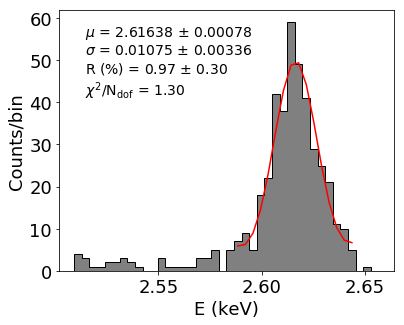

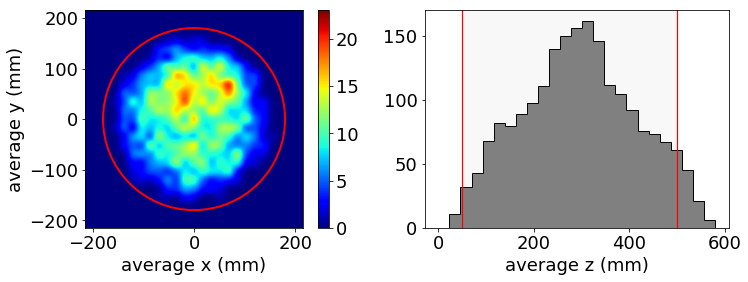

In [27]:
cuts_energy = C_basic & (A_rmax < cwide_rmax) & (A_zmin > cwide_zmin) & (A_zmax < cwide_zmax) & \
              (A_zlen > 35) & (A_zlen < 130) & (A_ntrks == 1)

if(z_corrected):
    
    fit_rng_low = 2.585 #StoE(2.720)
    fit_rng_high = 2.645 #StoE(2.73)
    
    f = plt_spectrum(A_Ecplot, cuts_energy, 
                  plt_rng_low = StoE(2.66),
                  plt_rng_high = StoE(2.82),
                  fit_rng_low = fit_rng_low,
                  fit_rng_high = fit_rng_high,
                  fit_gauss_A = 40,
                  fit_gauss_mu = 2.615, #StoE(2.775),
                  fit_gauss_sigma = StoE(0.01),
                  text_x = 1.002*StoE(2.66),
                  nbins = 40,
                  outfile_name = "CSTH_espectrum_Tl_fit")
    
    cuts_xyz = C_basic & (A_Ecplot > fit_rng_low) & (A_Ecplot < fit_rng_high)
    plt_xyz_distributions(A_xavg, A_yavg, A_zavg, cuts_xyz, 
                          nxybins = 25, 
                          nzbins = 25, 
                          zmin = cwide_zmin, 
                          zmax = cwide_zmax, 
                          rmax = cwide_rmax,
                          outfile_name = "CSTH_xyzdist_Tl")

    
else:

    fit_rng_low = StoE(2.60)
    fit_rng_high = StoE(2.77)
    
    f = plt_spectrum(A_Ecplot, cuts_energy, 
                  plt_rng_low = StoE(2.55),
                  plt_rng_high = StoE(2.80),
                  fit_rng_low = fit_rng_low,
                  fit_rng_high = fit_rng_high,
                  fit_gauss_A = 30,
                  fit_gauss_mu = StoE(2.72),
                  fit_gauss_sigma = StoE(0.01),
                  text_x = 1.001*StoE(2.55),
                  nbins = 40,
                  outfile_name = "CSTH_espectrum_Tl_fit_nozcorrection")
    
    cuts_xyz = C_basic & (A_Ecplot > fit_rng_low) & (A_Ecplot < fit_rng_high)
    plt_xyz_distributions(A_xavg, A_yavg, A_zavg, cuts_xyz, 
                          nxybins = 25, 
                          nzbins = 25, 
                          zmin = cwide_zmin, 
                          zmax = cwide_zmax, 
                          rmax = cwide_rmax,
                          outfile_name = "CSTH_xyzdist_Tl_nozcorrection")

# Save relevant values for later use.
mu_tl_fid, e_mu_tl_fid, sigma_tl_fid, e_sigma_tl_fid = f.values[1], f.errors[1], f.values[2], f.errors[2]

----

---

## Section D: Energy calibration

**Relevant fit points**
- $^{137}$Cs gamma, photopeak: 661.657 keV
- $^{208}$Tl gamma, double-escape peak: 1592.535 keV
- $^{208}$Tl gamma, photopeak: 2614.533 keV

## D.1: Definitions

In [ ]:
# A 2nd order polynomial
def poly2(x, a, b, c):
    return a*x**2 + b*x + c

In [ ]:
# Calibrated (tabulated) energies.
mu_cal = np.array([E_Cs, E_descape, E_Tl])/1000
sigma_cal = np.array([err_E_Cs, err_E_descape, err_E_Tl])/1000

# Uncalibrated energies.
mu_uncal = np.array([mu_cs_fid, mu_de_fid, mu_tl_fid])
sigma_uncal = np.array([e_mu_cs_fid, e_mu_de_fid, e_mu_tl_fid])
print("mu_uncal = ", mu_uncal)
print("sigma_uncal = ", sigma_uncal)
print("sigma_uncal/mu_uncal*100 = ", sigma_uncal/mu_uncal*100)

## D.2: Quadratic fit

In [ ]:
p, V = curve_fit(poly2, mu_uncal, mu_cal, sigma=sigma_cal, absolute_sigma=True)
a = p[0]
b = p[1]
c = p[2]
print("Fit parameters are: a = {}, b = {}, c = {}".format(a, b, c))

xfit = np.arange(0,3.0,0.01)
pfit = np.poly1d([a, b, c])
sigma_E  = np.array([0, 0, 0])

xres = xfit
res = 100*(mu_cal-pfit(mu_uncal))/mu_cal
res_err = 100*sigma_E/mu_cal
print("Residuals (%): {}".format(res))

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)
gs = gridspec.GridSpec(2, 1, height_ratios=[1,1]) 

ax1 = fig.add_subplot(gs[0])
ax1.plot(xfit, pfit(xfit), '--', color='gray')
ax1.plot(mu_uncal, mu_cal, '.', markerfacecolor='none', markersize=12, color='red')
#ax1.errorbar(mu_uncal, mu_cal, xerr=sigma_uncal, markersize=8, color='red', fmt='.')
ax1.set_ylabel('Nominal energy\n$E_0$ (keV)')
ax1.set_xlim(0,3.0)
#ax1.set_ylim(-0.02,1.02)

ax2 = fig.add_subplot(gs[1])
#ax2.errorbar(mu_uncal, res, yerr=res_err, capsize=5, fmt='.', markersize=6, color='red')
ax2.plot(mu_uncal, res, '.', markersize=6, color='red')
ax2.hlines(0.0,xmin=0.0,xmax=3.0,linestyle='--',color='gray',alpha=0.4)
ax2.set_xlabel('Raw energy, $Q$ (photoelectrons)')
ax2.set_ylabel('Residual (%)')
ax2.set_xlim(0,3.0)
ax2.set_ylim(-0.4,0.4)

plt.savefig("{}/CSTH_energy_calibration.{}".format(save_dir,save_ftype), bbox_inches='tight')

---

# Section E: Misc.

## E.1: Energy vs. time

In [ ]:
# Energy vs. time
cuts_T = C_wide

nbins = 8

print(A_time[0])
print(A_time[-1])

# for double-escape peak
Thist_min_D = A_time[0] #1531175.7
Thist_max_D = A_time[-1] #1531210.6
Ehist_min_D = 1.50
Ehist_max_D = 1.67
plt_rng_Tlow_D = A_time[0]
plt_rng_Thigh_D = A_time[-1]
plt_rng_Elow_D = 1.50
plt_rng_Ehigh_D = 1.67

# for Cs peak
Thist_min_Cs = A_time[0]
Thist_max_Cs = A_time[-1]
Ehist_min_Cs = 0.63
Ehist_max_Cs = 0.69
plt_rng_Tlow_Cs = A_time[0]
plt_rng_Thigh_Cs = A_time[-1]
plt_rng_Elow_Cs = 0.63
plt_rng_Ehigh_Cs = 0.69

fig = plt.figure()
fig.patch.set_alpha(0.0)
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
ax1.scatter(A_time[cuts_T],A_Ecplot[cuts_T],s=0.5)
#ax1.axhline(y=Ehist_min_D,c="red",linewidth=1.2,linestyle='dashed')
#ax1.axhline(y=Ehist_max_D,c="red",linewidth=1.2,linestyle='dashed')
plt.title("Energy vs. T")
plt.ylim([plt_rng_Elow_D,plt_rng_Ehigh_D])
plt.xlim([plt_rng_Tlow_D,plt_rng_Thigh_D])
plt.xlabel('T')
plt.ylabel('E (keV)')

ax5 = fig.add_subplot(122);
ax5.scatter(A_time[cuts_T],A_Ecplot[cuts_T],s=0.5)
#ax5.axhline(y=Ehist_min_Cs,c="red",linewidth=1.2,linestyle='dashed')
#ax5.axhline(y=Ehist_max_Cs,c="red",linewidth=1.2,linestyle='dashed')
plt.title("Energy vs. T")
plt.ylim([plt_rng_Elow_Cs,plt_rng_Ehigh_Cs])
plt.xlim([plt_rng_Tlow_Cs,plt_rng_Thigh_Cs])
plt.xlabel('T')
plt.ylabel('E (keV)')

plt.savefig("{}/CSTH_E_vs_T.{}".format(save_dir,save_ftype), bbox_inches='tight')

---